In [111]:
!pwd

/Users/neku5162/Desktop/sir_inversions/2_line_run


In [95]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d, UnivariateSpline
from astropy.io import fits
from sklearn.cluster import KMeans

In [96]:
d1 = fits.open('sir_t.fits')
d2 = fits.open('sir_p.fits')
d3 = fits.open('sir_pe.fits')
d4 = fits.open('sir_vlos.fits')
d5 = fits.open('sir_z.fits')
d6 = fits.open('sir_vmic.fits')
d7 = fits.open('sir_rho.fits')

# Throw away bottom of the atmosphere (stuff nan's out beyond log tau = 1.4)

In [46]:
cube_t = d1[0].data[:,:,6:64]  
cube_p = d2[0].data[:,:,6:64] 
cube_pe = d3[0].data[:,:,6:64] 
cube_vlos = d4[0].data[:,:,6:64] 
cube_z = d5[0].data[:,:,6:64] 
cube_vmic = d6[0].data[:,:,6:64] 
cube_rho = d7[0].data[:,:,6:64] 

In [15]:
def readsim(file):
    raw = np.loadtxt(file)
    return np.transpose(raw.reshape((64,252,252)))

In [16]:
sim_z = np.loadtxt('z_100.csv') *10.0**(5.0) # cgs units [sim_z is a global value of the simulation domain.]
dx = 23.809496*10.0**(5.0)
dy = 23.809496*10.0**(5.0)

mu = 1.2904  # from rh
kb = 1.38064852*10.0**(-16.0) # cgs 
amu = 1.660540*10**(-24.0) # cgs 
g = 27400.0



In [17]:
sim_tau = np.log10(readsim('tau_100.csv')[:,:,1:])
sim_temp = readsim('t_100.csv')
sim_tau = np.append(np.zeros((252,252,1))-6.0,sim_tau,axis=2) ## append log tau = -6 a

In [18]:
raw_spectra = np.transpose(np.loadtxt('spectrum.csv').reshape((257,252,252)))

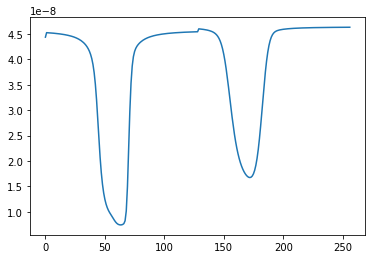

In [20]:
plt.plot(raw_spectra[10,10,:])

In [41]:
tau_sir = np.linspace(1.4,-4.3,num=58) # again we're throwing away the bottom values of tau in SIR inversions

In [21]:
# again we're throwing away the bottom values of tau in SIR inversions

# Now do clustering on spectra

In [25]:
kmeans_raw = KMeans(n_clusters=5,init = 'k-means++' , random_state=5).fit(raw_spectra.reshape((252*252,257)))

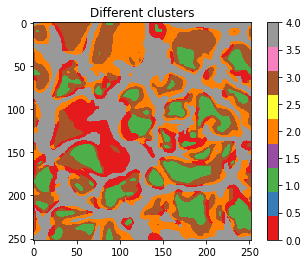

In [28]:
plt.imshow(kmeans_raw.labels_.reshape((252,252)),cmap='Set1')
plt.colorbar()
plt.title('Different clusters')
plt.show()

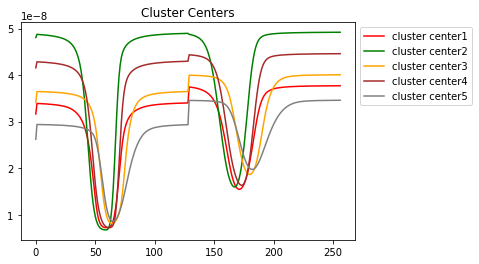

In [29]:
colors = ['red','green', 'orange', 'brown','grey']
for i in np.arange(5):
    plt.plot(kmeans_raw.cluster_centers_[i],label = 'cluster center' + str(i+1),color = colors[i])
    plt.legend()
plt.title('Cluster Centers')
plt.legend(bbox_to_anchor=(1, 0, 0, 1))

# Construct average z vs tau for each cluster

In [47]:
tau_cluster_1 = np.zeros(64)
tau_cluster_2 = np.zeros(64)
tau_cluster_3 = np.zeros(64)
tau_cluster_4 = np.zeros(64)
tau_cluster_5 = np.zeros(64)

cluster_labels = kmeans_raw.labels_.reshape((252,252))

num1 = np.count_nonzero(cluster_labels.flatten() == 0)
num2 = np.count_nonzero(cluster_labels.flatten() == 1)
num3 = np.count_nonzero(cluster_labels.flatten() == 2)
num4 = np.count_nonzero(cluster_labels.flatten() == 3)
num5 = np.count_nonzero(cluster_labels.flatten() == 4)


for i in np.arange(252):
    for j in np.arange(252):

        if cluster_labels[i,j] == 0:
            tau_cluster_1 += sim_tau[i,j,:]

        if cluster_labels[i,j] == 1:
            tau_cluster_2 += sim_tau[i,j,:]
            
        if cluster_labels[i,j] == 2:
            tau_cluster_3 += sim_tau[i,j,:]
            
        if cluster_labels[i,j] == 3:
            tau_cluster_4 += sim_tau[i,j,:]

        if cluster_labels[i,j] == 4:
            tau_cluster_5 += sim_tau[i,j,:]

    
tau_cluster_1= tau_cluster_1/num1
tau_cluster_2= tau_cluster_2/num2
tau_cluster_3= tau_cluster_3/num3
tau_cluster_4= tau_cluster_4/num4
tau_cluster_5= tau_cluster_5/num5

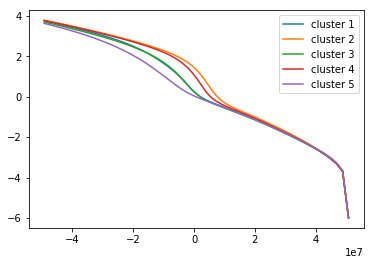

In [48]:
plt.plot(sim_z,tau_cluster_1,label = 'cluster 1')
plt.plot(sim_z,tau_cluster_2,label = 'cluster 2')
plt.plot(sim_z,tau_cluster_3,label = 'cluster 3')
plt.plot(sim_z,tau_cluster_4,label = 'cluster 4')
plt.plot(sim_z,tau_cluster_5,label = 'cluster 5')
plt.legend()


# Now interpolate the entire SIR cube

In [49]:


# gives z as a function of tau based off Muram
z_c1 = interp1d(tau_cluster_1, (1e-5)*sim_z[:],kind='linear')
z_c2 = interp1d(tau_cluster_2, (1e-5)*sim_z[:],kind='linear')
z_c3 = interp1d(tau_cluster_3, (1e-5)*sim_z[:],kind='linear')
z_c4 = interp1d(tau_cluster_4, (1e-5)*sim_z[:],kind='linear')
z_c5 = interp1d(tau_cluster_5, (1e-5)*sim_z[:],kind='linear')

# gives tau as a function of z based off Muram (inverse of above...)

tau_c1 = interp1d((1e-5)*sim_z[:],tau_cluster_1,kind='linear',fill_value='extrapolate')
tau_c2 = interp1d((1e-5)*sim_z[:],tau_cluster_2,kind='linear',fill_value='extrapolate')
tau_c3 = interp1d((1e-5)*sim_z[:],tau_cluster_3,kind='linear',fill_value='extrapolate')
tau_c4 = interp1d((1e-5)*sim_z[:],tau_cluster_4,kind='linear',fill_value='extrapolate')
tau_c5 = interp1d((1e-5)*sim_z[:],tau_cluster_5,kind='linear',fill_value='extrapolate')



In [50]:
cube_p.shape

(252, 252, 58)

In [51]:


cluster_z_cube = np.zeros((252,252,58))  # cluster_z_cube is an array of the interpolated z positions down each pixel

for i in np.arange(252):
    for j in np.arange(252):
        
        if cluster_labels[i,j] == 0:
            cluster_z_cube[i,j] = z_c1(tau_sir)

        if cluster_labels[i,j] == 1:
            cluster_z_cube[i,j] = z_c2(tau_sir)
            
        if cluster_labels[i,j] == 2:
            cluster_z_cube[i,j] = z_c3(tau_sir)
            
        if cluster_labels[i,j] == 3:
            cluster_z_cube[i,j] = z_c4(tau_sir)

        if cluster_labels[i,j] == 4:
            cluster_z_cube[i,j] = z_c5(tau_sir)


In [112]:
# This his only for temperature, but eventually we need to do it for all other quantities too

def cluster_reconstruct(k_index):
    tau_avg = np.mean(sim_tau[:,:,k_index]) # average value of log tau at this height
    z_val = sim_z[k_index] # True z value for this index
    true_temp = sim_temp[:,:,k_index] # temperature at this height in simulation
    
    plt.imshow(gaussian_filter(true_temp,1),cmap='inferno')
    
    tup = np.max(true_temp)
    tlo = np.min(true_temp)
    
    plt.colorbar()
    plt.clim(tlo,tup)
    plt.title('Temp at z = '+str(round(z_val*(1e-5),2))+'km ($tau \sim$' + str(round(tau_avg,2))+ ')')
    plt.savefig('t_original.png')
    plt.show()
    
    
    ### Now do SIR
    
    tau_c1_val = tau_c1(z_val*(1e-5))
    tau_c2_val = tau_c2(z_val*(1e-5))
    tau_c3_val = tau_c3(z_val*(1e-5))
    tau_c4_val = tau_c4(z_val*(1e-5))
    tau_c5_val = tau_c5(z_val*(1e-5))

    sir_reconstruct_temp = np.zeros((252,252))  # reconstruct temperatures based on inferred positions

    for i in np.arange(252):
        for j in np.arange(252):
            
            sir_temp_tau = interp1d(tau_sir,cube_t[i,j,:],fill_value='extrapolate')  # interpolate temperature values on tau grid 
            
            if cluster_labels[i,j] == 0:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c1_val)
            if cluster_labels[i,j] == 1:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c2_val)
            if cluster_labels[i,j] == 2:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c3_val)
            if cluster_labels[i,j] == 3:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c4_val)
            if cluster_labels[i,j] == 4:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c5_val)
                
            
    
    plt.imshow(gaussian_filter(sir_reconstruct_temp,1),cmap='inferno')
    plt.colorbar()
    plt.clim(tlo,tup)
    plt.title('Reconstructed temp at z = '+str(round(z_val*(1e-5),2))+'km ($tau \sim$' + str(round(tau_avg,2))+ ')')
    plt.savefig('t_recons.png')
    plt.show()

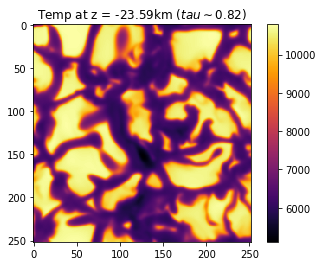

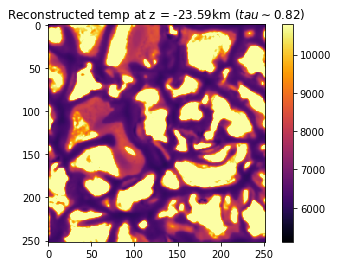

In [55]:
cluster_reconstruct(30)

In [79]:
def reconstruct_all():
    sir_reconstruct_temp = np.zeros((252,252,64))  
    sir_reconstruct_vlos = np.zeros((252,252,64))  
    sir_reconstruct_p = np.zeros((252,252,64))  
    sir_reconstruct_pe = np.zeros((252,252,64))  
    sir_reconstruct_vmic = np.zeros((252,252,64))  
    sir_reconstruct_rho = np.zeros((252,252,64))  

    for i in np.arange(252):
        for j in np.arange(252):
            # interpolate physical parameters onto tau scale (so I can fill in missing values of tau)
            sir_temp_tau = interp1d(tau_sir,cube_t[i,j,:],fill_value='extrapolate') 
            sir_vlos_tau = interp1d(tau_sir,cube_vlos[i,j,:],fill_value='extrapolate')  
            sir_p_tau = interp1d(tau_sir,np.log(cube_p[i,j,:]),fill_value='extrapolate')  
            sir_pe_tau = interp1d(tau_sir,np.log(cube_pe[i,j,:]),fill_value='extrapolate') 
            sir_vmic_tau = interp1d(tau_sir,np.log(cube_vmic[i,j,:]),fill_value='extrapolate') 
            sir_rho_tau = interp1d(tau_sir,np.log(cube_rho[i,j,:]),fill_value='extrapolate') 
            
            if cluster_labels[i,j] == 0:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c1(sim_z*(1e-5)))
                sir_reconstruct_vlos[i,j] = sir_vlos_tau(tau_c1(sim_z*(1e-5)))
                sir_reconstruct_p[i,j] = sir_p_tau(tau_c1(sim_z*(1e-5)))
                sir_reconstruct_pe[i,j] = sir_pe_tau(tau_c1(sim_z*(1e-5)))
                sir_reconstruct_vmic[i,j] = sir_vmic_tau(tau_c1(sim_z*(1e-5)))
                sir_reconstruct_rho[i,j] = sir_rho_tau(tau_c1(sim_z*(1e-5)))

            if cluster_labels[i,j] == 1:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c2(sim_z*(1e-5)))
                sir_reconstruct_vlos[i,j] = sir_vlos_tau(tau_c2(sim_z*(1e-5)))
                sir_reconstruct_p[i,j] = sir_p_tau(tau_c2(sim_z*(1e-5)))
                sir_reconstruct_pe[i,j] = sir_pe_tau(tau_c2(sim_z*(1e-5)))
                sir_reconstruct_vmic[i,j] = sir_vmic_tau(tau_c2(sim_z*(1e-5)))
                sir_reconstruct_rho[i,j] = sir_rho_tau(tau_c2(sim_z*(1e-5)))
            
            if cluster_labels[i,j] == 2:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c3(sim_z*(1e-5)))
                sir_reconstruct_vlos[i,j] = sir_vlos_tau(tau_c3(sim_z*(1e-5)))
                sir_reconstruct_p[i,j] = sir_p_tau(tau_c3(sim_z*(1e-5)))
                sir_reconstruct_pe[i,j] = sir_pe_tau(tau_c3(sim_z*(1e-5)))
                sir_reconstruct_vmic[i,j] = sir_vmic_tau(tau_c3(sim_z*(1e-5)))
                sir_reconstruct_rho[i,j] = sir_rho_tau(tau_c3(sim_z*(1e-5)))
            
            if cluster_labels[i,j] == 3:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c4(sim_z*(1e-5)))
                sir_reconstruct_vlos[i,j] = sir_vlos_tau(tau_c4(sim_z*(1e-5)))
                sir_reconstruct_p[i,j] = sir_p_tau(tau_c4(sim_z*(1e-5)))
                sir_reconstruct_pe[i,j] = sir_pe_tau(tau_c4(sim_z*(1e-5)))
                sir_reconstruct_vmic[i,j] = sir_vmic_tau(tau_c4(sim_z*(1e-5)))
                sir_reconstruct_rho[i,j] = sir_rho_tau(tau_c4(sim_z*(1e-5)))

            if cluster_labels[i,j] == 4:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c5(sim_z*(1e-5)))
                sir_reconstruct_vlos[i,j] = sir_vlos_tau(tau_c5(sim_z*(1e-5)))
                sir_reconstruct_p[i,j] = sir_p_tau(tau_c5(sim_z*(1e-5)))
                sir_reconstruct_pe[i,j] = sir_pe_tau(tau_c5(sim_z*(1e-5)))
                sir_reconstruct_vmic[i,j] = sir_vmic_tau(tau_c5(sim_z*(1e-5)))
                sir_reconstruct_rho[i,j] = sir_rho_tau(tau_c5(sim_z*(1e-5)))
                    
    return [sir_reconstruct_temp,sir_reconstruct_vlos,np.e**sir_reconstruct_p,np.e**sir_reconstruct_pe,np.e**sir_reconstruct_vmic,np.e**sir_reconstruct_rho]


# recpnstruction for all quantities. Note that , we interpolate pressures and densities logarithmically and temperatures linearly

In [57]:
sir_atmos_raw =reconstruct_all()

In [58]:
! rm recons_*.fits  # clear old files

In [59]:
# Now write things in a format and units that RH can read
out_arr = np.transpose(sir_atmos_raw[0])
hdu = fits.PrimaryHDU(out_arr)
hdu.writeto('recons_'+'t'+'.fits')

out_arr = np.transpose(sir_atmos_raw[1]*(1e-5)*(-1.0))
hdu = fits.PrimaryHDU(out_arr)
hdu.writeto('recons_'+'vz'+'.fits')

out_arr = np.transpose(sir_atmos_raw[5]/(mu*amu)*(1e6))
hdu = fits.PrimaryHDU(out_arr)
hdu.writeto('recons_'+'nh'+'.fits')

out_arr = np.transpose(sir_atmos_raw[3]/(sir_atmos_raw[0]*kb)*(1e6))
hdu = fits.PrimaryHDU(out_arr)
hdu.writeto('recons_'+'nelec'+'.fits')

out_arr = np.transpose(sir_atmos_raw[4]*(1e-5))
hdu = fits.PrimaryHDU(out_arr)
hdu.writeto('recons_'+'vturb'+'.fits')

In [82]:
!pwd

/Users/neku5162/Desktop/sir_inversions/2_line_run


In [83]:
# load rh files directly from read3datmos and make sure my input SIR atmosphere has the same structure and units


In [84]:
names = ['temp','vlos','p','pe','vmic','rho']

In [85]:
awd = fits.open('rh_nh.fits')
rh_nh = awd[0].data

awd = fits.open('rh_nelec.fits')
rh_nelec = awd[0].data

awd = fits.open('rh_t.fits')
rh_t = awd[0].data

awd = fits.open('rh_vz.fits')
rh_vz = awd[0].data

awd = fits.open('recons_nh.fits')
recons_nh = awd[0].data

awd = fits.open('recons_nelec.fits')
recons_nelec = awd[0].data

awd = fits.open('recons_t.fits')
recons_t = awd[0].data

awd = fits.open('recons_vz.fits')
recons_vz = awd[0].data

awd = fits.open('recons_vturb.fits')
recons_vturb = awd[0].data

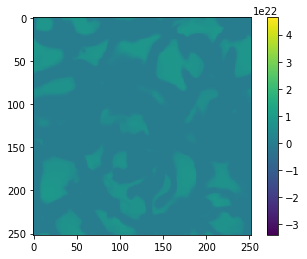

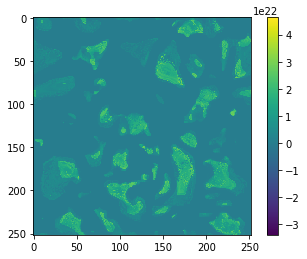

In [109]:
k = 28

plt.imshow(rh_nelec[k,:,:])
plt.colorbar()

cup = np.mean(rh_nelec) + 2.0*np.std(rh_nelec)
clo = np.min(rh_nelec) - 2.0*np.std(rh_nelec)
plt.clim(clo,cup)
plt.show()

plt.imshow(recons_nelec[k,:,:])
plt.colorbar()
plt.clim(clo,cup)

plt.show()

In [110]:
np.min(recons_nh)

1e+21

In [91]:
#set thresholds and rewrite arrays

recons_t[recons_t < 3000.0] = 3000.0
recons_t[recons_t > 15000.0] = 15000.0

recons_nh[recons_nh < 1e21] =  1e21
recons_nh[recons_nh > 1e23] =  1e23

recons_nelec[recons_nelec < 1e19] =  1e19
recons_nelec[recons_nelec > 1e23] =  1e23

recons_vz[recons_vz < -15.0] =  -15.0
recons_vz[recons_vz > 15.0] =  15.0

In [92]:
! rm recons_*.fits

In [93]:
hdu = fits.PrimaryHDU(recons_t)
hdu.writeto('recons_t.fits')

hdu = fits.PrimaryHDU(recons_nh)
hdu.writeto('recons_nh.fits')

hdu = fits.PrimaryHDU(recons_nelec)
hdu.writeto('recons_nelec.fits')

hdu = fits.PrimaryHDU(recons_vz)
hdu.writeto('recons_vz.fits')

hdu = fits.PrimaryHDU(recons_vturb)
hdu.writeto('recons_vturb.fits')

In [94]:
! cp recons_*.fits /Users/neku5162/rh/rhsc3d/sir_recons/

# Will RH run?

# Velocities and frequency integration?